# Understand Standard Modules in a Detector

A detector usually consists of:

- a backbone, to generate multi-stage feature maps
- a feature pyramid network, to fuse features of different stages
- a dense prediction head, to predict object at different locations
- (optinally) sparse head for two-stage and multi-stage detectors

This image is from YOLO v4

![](https://miro.medium.com/max/720/1*Z5GOPYFgh7_NTr7drt45mw.png)

In MMDetection, components are defined in `model` key in the config file.

In this notebook, we investigate these modules interatively, and understand the connection between Python modules and config files. 

We use RetinaNet and FCOS as example.

Architecture: 

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_3.34.09_PM_SAg1OBo.png" alt="Architecture" style="width: 800px;"/>

## Backbone

We define a ResNet backbone that output feature map C2 to C5.

Here index 0 indicates C2.

In [1]:
from mmdet.models.backbones import ResNet

backbone = ResNet(depth=18, out_indices=(0,1,2,3))

/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/model/utils.py:138: UserWarning: Cannot import torch.fx, `merge_dict` is a simple function to merge multiple dicts
  warnings.warn('Cannot import torch.fx, `merge_dict` is a simple function '


We forward a random tensor and check the output

In [2]:
import torch

img = torch.rand(1,3,1000,600)

In [3]:
bbout = backbone(img)

In [4]:
for o in bbout:
    print(o.shape)

torch.Size([1, 64, 250, 150])
torch.Size([1, 128, 125, 75])
torch.Size([1, 256, 63, 38])
torch.Size([1, 512, 32, 19])


These tensors are downsampled from 4x to 32x respectively. 

## Neck

We define a plain feature pyramid network to fuse different modules. 

`start_level=1` means index 1 from the backbone, which is C3. 

In [5]:
from mmdet.models.necks import FPN

In [6]:
neck = FPN(in_channels=[64, 128, 256, 512], start_level=1, out_channels=256, num_outs=5)

In [7]:
ncout = neck(bbout)

for o in ncout:
    print(o.shape)

torch.Size([1, 256, 125, 75])
torch.Size([1, 256, 63, 38])
torch.Size([1, 256, 32, 19])
torch.Size([1, 256, 16, 10])
torch.Size([1, 256, 8, 5])


The neck outputs fused features of all 5 levels, with same number of channels. 
Down-sampling rates ranges from 8x to 128x.

## Anchor-free Heads

An anchor-free head slides on the feature map and compute predictions directly (compared to anchor-based heads which compute prediction referenced to anchors).

In [8]:
from mmdet.models.dense_heads import FCOSHead

In [9]:
head = FCOSHead(num_classes=20, in_channels=256)

02/08 16:02:52 - mmengine - WARNING - The "model" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.
02/08 16:02:52 - mmengine - WARNING - The "task util" registry in mmdet did not set import location. Fallback to call `mmdet.utils.register_all_modules` instead.


In [10]:
hout = head(ncout)

print(F"type: {type(hout)}")
print(F"length: {len(hout)}")

type: <class 'tuple'>
length: 3


In [11]:
for res in hout:
    for o in res:
        print(o.shape)

torch.Size([1, 20, 125, 75])
torch.Size([1, 20, 63, 38])
torch.Size([1, 20, 32, 19])
torch.Size([1, 20, 16, 10])
torch.Size([1, 20, 8, 5])
torch.Size([1, 4, 125, 75])
torch.Size([1, 4, 63, 38])
torch.Size([1, 4, 32, 19])
torch.Size([1, 4, 16, 10])
torch.Size([1, 4, 8, 5])
torch.Size([1, 1, 125, 75])
torch.Size([1, 1, 63, 38])
torch.Size([1, 1, 32, 19])
torch.Size([1, 1, 16, 10])
torch.Size([1, 1, 8, 5])


FCOS head predict:

- Class probabilities of 20 dimension
- Bounding box coodinates of 4 dimension 
- Centereness of 1 dimension 

at all positions on all levels of feature maps.


During inference, post-processing like thresholding and NMS will produce final detection boxes. 

During training, predictions will be compared with ground-truth to produce loss

## Anchor-based Heads

Anchor-based head is programmingly more complex as it contains an anchor generation module. Let's investigate this first.

In [12]:
from mmdet.core.anchor import AnchorGenerator
# from mmdet.models.task_modules import AnchorGenerator # for v2.0

ag = AnchorGenerator(
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64])

In [13]:
bbx = ag.single_level_grid_priors(featmap_size=(125,75), level_idx=1)
bbx = ag.gen_base_anchors()
print(bbx)

[tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
        [-16.0000, -16.0000,  16.0000,  16.0000],
        [-11.3137, -22.6274,  11.3137,  22.6274]]), tensor([[-45.2548, -22.6274,  45.2548,  22.6274],
        [-32.0000, -32.0000,  32.0000,  32.0000],
        [-22.6274, -45.2548,  22.6274,  45.2548]]), tensor([[-90.5097, -45.2548,  90.5097,  45.2548],
        [-64.0000, -64.0000,  64.0000,  64.0000],
        [-45.2548, -90.5097,  45.2548,  90.5097]]), tensor([[-181.0193,  -90.5097,  181.0193,   90.5097],
        [-128.0000, -128.0000,  128.0000,  128.0000],
        [ -90.5097, -181.0193,   90.5097,  181.0193]]), tensor([[-362.0387, -181.0193,  362.0387,  181.0193],
        [-256.0000, -256.0000,  256.0000,  256.0000],
        [-181.0193, -362.0387,  181.0193,  362.0387]])]


/home/cine/miniconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:163: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


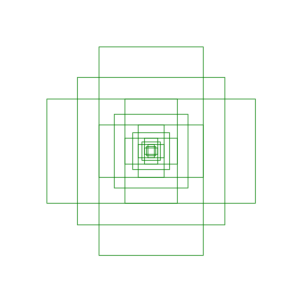

In [14]:
from mmengine.visualization import Visualizer
import numpy as np

vis = Visualizer(image = np.ones((1000,1000,3))*255)
for b in bbx:
    vis.draw_bboxes(b+500)
vis.show()

Anchors of different size will be assigned to feature maps of different levels.

We then construct an anchor-based head based on this anchor generator.

In [15]:
from mmdet.models.dense_heads import RetinaHead
abhead = RetinaHead(in_channels=256,
                    num_classes=20,
                    anchor_generator=dict(
                        type='AnchorGenerator',
                        octave_base_scale=4,
                        scales_per_octave=3,
                        ratios=[0.5, 1.0, 2.0],
                        strides=[8, 16, 32, 64, 128]))

In [16]:
from mmdet.models.dense_heads import RPNHead
abhead = RPNHead(in_channels=256,
                 anchor_generator=dict(
                    type='AnchorGenerator',
                    scales=[8, 16, 32],
                    ratios=[0.5, 1.0, 2.0],
                    strides=[8, 16, 32, 64, 128]))

In [17]:
out = abhead(ncout)
cls, bbx = out

In [18]:
for o in cls:
    print(o.shape)

torch.Size([1, 9, 125, 75])
torch.Size([1, 9, 63, 38])
torch.Size([1, 9, 32, 19])
torch.Size([1, 9, 16, 10])
torch.Size([1, 9, 8, 5])


In [19]:
for o in bbx:
    print(o.shape)

torch.Size([1, 36, 125, 75])
torch.Size([1, 36, 63, 38])
torch.Size([1, 36, 32, 19])
torch.Size([1, 36, 16, 10])
torch.Size([1, 36, 8, 5])
